O link para os arquivos esta aqui: https://drive.google.com/drive/folders/1hiuuzwvlUpnH3u9QP0Rqu1UMKo7CRCww?usp=drive_link


# Importacao das bibliotecas e analises

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
customers = spark.read.csv('/content/drive/MyDrive/ProjetoFinal/Arquivos/olist_customers_dataset.csv', header=True, inferSchema=True)
geolocation = spark.read.csv('/content/drive/MyDrive/ProjetoFinal/Arquivos/olist_geolocation_dataset.csv', header=True, inferSchema=True)
order_items = spark.read.csv('/content/drive/MyDrive/ProjetoFinal/Arquivos/olist_order_items_dataset.csv', header=True, inferSchema=True)
order_payments = spark.read.csv('/content/drive/MyDrive/ProjetoFinal/Arquivos/olist_order_payments_dataset.csv', header=True, inferSchema=True)
order_reviews = spark.read.csv('/content/drive/MyDrive/ProjetoFinal/Arquivos/olist_order_reviews_dataset.csv', header=True, inferSchema=True)
orders_dataset = spark.read.csv('/content/drive/MyDrive/ProjetoFinal/Arquivos/olist_orders_dataset.csv', header=True, inferSchema=True)
products_dataset = spark.read.csv('/content/drive/MyDrive/ProjetoFinal/Arquivos/olist_products_dataset.csv', header=True, inferSchema=True)

In [ ]:
customers.na.drop()
geolocation.na.drop()
order_items.na.drop()
order_payments.na.drop()
order_reviews.na.drop()
orders_dataset.na.drop()
products_dataset.na.drop()

DataFrame[product_id: string, product_category_name: string, product_name_lenght: int, product_description_lenght: int, product_photos_qty: int, product_weight_g: int, product_length_cm: int, product_height_cm: int, product_width_cm: int]

In [ ]:
# Extraindo o mes e o ano da data da tabela de ordens
orders_dataset = orders_dataset.withColumn("Year", year(col('order_purchase_timestamp')))
orders_dataset = orders_dataset.withColumn("Month", month(col('order_purchase_timestamp')))

In [ ]:
orders_dataset.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+----+-----+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|Year|Month|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+----+-----+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:33|2017-10-02 11:07:15|         2017-10-04 19:55:00|          2017-10-10 21:25:13|          2017-10-18 00:00:00|2017|   10|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:37|2018-07-26 03:24:27|         2018-07-26 14:31:00|          2018-08-07 15:27:45|          2018-08-13 00:00:00|20

In [ ]:
# Como na tabela 'payments' nao temos datas, precisamos extrair de outra tabela usando join com 'orders_dataset' atraves da coluna 'order_id'
join_payments_order = orders_dataset.join(order_payments, 'order_id').groupBy('order_purchase_timestamp', 'Year', 'Month').agg(sum('payment_value').alias('sum_total')).orderBy('Year', 'Month')

In [ ]:
join_payments_order.show(5)

+------------------------+----+-----+---------+
|order_purchase_timestamp|Year|Month|sum_total|
+------------------------+----+-----+---------+
|     2016-09-13 15:24:19|2016|    9|    40.95|
|     2016-09-04 21:15:19|2016|    9|   136.23|
|     2016-09-05 00:15:34|2016|    9|    75.06|
|     2016-10-06 18:03:01|2016|   10|    89.16|
|     2016-10-05 22:53:45|2016|   10|    123.2|
+------------------------+----+-----+---------+
only showing top 5 rows



In [ ]:
# calculando o ticket medio das vendas
avg_payment = order_payments.select(avg('payment_value'))
avg_payment.show()

+------------------+
|avg(payment_value)|
+------------------+
|154.10038041698587|
+------------------+



In [ ]:
# tempo de envio
orders_dataset.select('order_purchase_timestamp', 'order_delivered_customer_date', (col('order_delivered_customer_date') - col('order_purchase_timestamp')).alias('tempo_entrega'))

DataFrame[order_purchase_timestamp: timestamp, order_delivered_customer_date: timestamp, tempo_entrega: interval day to second]

In [ ]:
orders_dataset.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+----+-----+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|Year|Month|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+----+-----+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:33|2017-10-02 11:07:15|         2017-10-04 19:55:00|          2017-10-10 21:25:13|          2017-10-18 00:00:00|2017|   10|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:37|2018-07-26 03:24:27|         2018-07-26 14:31:00|          2018-08-07 15:27:45|          2018-08-13 00:00:00|20

In [ ]:
# contagem de vendas por ano por cada modalidade de pagamento
qtde_vendas_ano = order_payments.groupBy('payment_type').agg(count('order_id').alias('contagem'))

In [ ]:
qtde_vendas_ano.show()

+------------+--------+
|payment_type|contagem|
+------------+--------+
|      boleto|   19784|
| not_defined|       3|
| credit_card|   76795|
|     voucher|    5775|
|  debit_card|    1529|
+------------+--------+



In [ ]:
# quantidade de vendas agrupada por mes e ano
qtde_venda_mes = orders_dataset.groupBy('Year', 'Month').agg(count_distinct('order_id').alias('vendas_mes')).orderBy('Year', 'Month')

In [ ]:
qtde_venda_mes.show(5)

+----+-----+----------+
|Year|Month|vendas_mes|
+----+-----+----------+
|2016|    9|         4|
|2016|   10|       324|
|2016|   12|         1|
|2017|    1|       800|
|2017|    2|      1780|
+----+-----+----------+
only showing top 5 rows



In [ ]:
# Extraindo o mes e o ano da data da tabela de 'reviews'
order_reviews = order_reviews.withColumn("Year", year(col('review_creation_date')))
order_reviews = order_reviews.withColumn("Month", month(col('review_creation_date')))

In [ ]:
order_reviews.show(5)

+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+----+-----+
|           review_id|            order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|Year|Month|
+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+----+-----+
|7bc2406110b926393...|73fc7af87114b3971...|           4|                NULL|                  NULL| 2018-01-18 00:00:00|    2018-01-18 21:46:59|2018|    1|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|                NULL|                  NULL| 2018-03-10 00:00:00|    2018-03-11 03:05:13|2018|    3|
|228ce5500dc1d8e02...|f9e4b658b201a9f2e...|           5|                NULL|                  NULL| 2018-02-17 00:00:00|    2018-02-18 14:36:24|2018|    2|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|  

In [ ]:
# calculando a media de avaliacao para cada mes do ano para descobrir os meses com maior e menor avaliacao
# assim e possivel observar a evolucao das avaliacoes pelos anos
# calculando a variancia podemos observar tambem a variacao dos valores de cada mes em relacao a media
media_variancia_avaliacao = order_reviews.groupBy('Year', 'Month').agg(avg('review_score').alias('media_avaliacao'),variance('review_score').alias('variancia_avaliacao')).orderBy('Year', 'Month')

In [ ]:
media_variancia_avaliacao.show(5)

+----+-----+------------------+-------------------+
|Year|Month|   media_avaliacao|variancia_avaliacao|
+----+-----+------------------+-------------------+
|NULL| NULL| 3.456122448979592|   4.79266472600778|
|2016|   10| 4.063291139240507| 1.9704910102394584|
|2016|   11|3.2903225806451615| 2.9256661991584854|
|2016|   12|2.3555555555555556| 3.5070707070707074|
|2017|    1| 4.343612334801762|  1.341585123387003|
+----+-----+------------------+-------------------+
only showing top 5 rows



# Relatorio:

## Com as informacoes obtidas, podemos tirar algumas conclusoes baseadas nos dados

##### 1. Calculando a media em pagamentos (order_pyments) podemos descobrir o valor do ticket medio, ou seja, o valor medio que alguem gasta na loja por cada compra

##### 2. Com o tempo de envio podemos verificar a quantidade de dias de entrega para cada pedido

##### 3. A contagem de vendas por meio de pagamento, a empresa consegue verificar a preferencia do cliente quanto aos meio de pagamento. Podemos verificar que os meios de pagamentos favoritos sao cartao de credito e boleto

##### 4. A quantidade de vendas agrupadas por mes e ano nos mostra o volume de vendas a cada mes, onde e possivel verificar um aumento na quantidade de vendas mes a mes

##### 5. Com a media de avaliacao por cada mes, podemos verificar a modificacao das avaliacoes ao longo dos meses e anos. Calculando a variancia podemos observar tambem a variacao dos valores de cada mes em relacao a media

# Graficos

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# convertendo o dataFrame em Pandas
qtde_vendas_ano = qtde_vendas_ano.toPandas()
print(qtde_vendas_ano)
qtde_vendas_ano = qtde_vendas_ano.drop(index=1)
print(qtde_vendas_ano)

  payment_type  contagem
0       boleto     19784
1  not_defined         3
2  credit_card     76795
3      voucher      5775
4   debit_card      1529
  payment_type  contagem
0       boleto     19784
2  credit_card     76795
3      voucher      5775
4   debit_card      1529


Text(0.5, 1.0, 'Distribuição das vendas por tipo de pagamento')

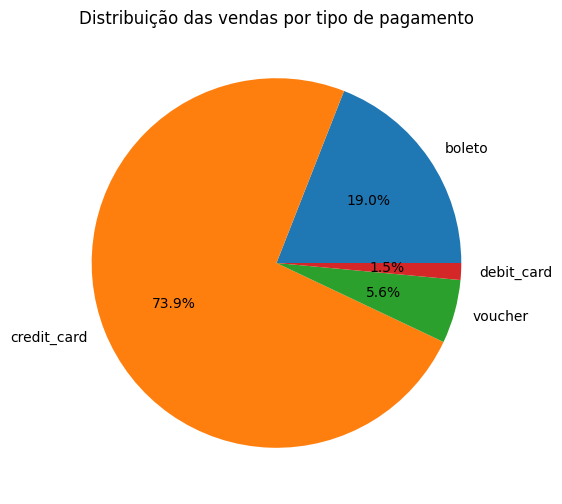

In [ ]:
fig1 = plt.figure(figsize=(6, 6))
plt.pie(qtde_vendas_ano['contagem'], labels=qtde_vendas_ano['payment_type'], autopct='%1.1f%%')
plt.title('Distribuição das vendas por tipo de pagamento')

In [ ]:
customers.show(5)
geolocation.show(5)

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
|4e7b3e00288586ebd...|060e732b5b29e8181...|                    1151|           sao paulo|            SP|
|b2b6027bc5c5109e5...|259dac757896d24d7...|                    8775|     mogi das cruzes|            SP|
|4f2d8ab171c80ec83...|345ecd01c38d18a90...|                   13056|            campinas|            SP|
+--------------------+--------------------+------------------------+--------------------+--------------+
only showing top 5 rows

+---------------------------+-

In [ ]:
# usar join para usar o costumer id junto da localizacao e contar a quantidade de cada cidade
# usar avg para encontrar a media da latitude e longitude para cada cidade e agrupar por estado e cidade
customer_geo_agrupado = customers.join(
    geolocation, geolocation.geolocation_zip_code_prefix == customers.customer_zip_code_prefix, "left").groupBy(
        "customer_state", "customer_city").agg(
    count("customer_id").alias("frequencia"),
    avg("geolocation_lat").alias("media_latitude"),
    avg("geolocation_lng").alias("media_longitude")
).orderBy(col("frequencia").desc())

In [ ]:
customer_geo_agrupado.show(5)

+--------------+--------------+----------+-------------------+------------------+
|customer_state| customer_city|frequencia|     media_latitude|   media_longitude|
+--------------+--------------+----------+-------------------+------------------+
|            RJ|rio de janeiro|   1913966| -22.93344308887008|-43.29874957795107|
|            SP|     sao paulo|   1372376|-23.575043281496608|-46.63129062506303|
|            MG|belo horizonte|    737548| -19.92003368888712|-43.95138358218058|
|            RJ|       niteroi|    452857|-22.893381665978687|-43.09646029150002|
|            PR|      curitiba|    255744| -25.44854199458171| -49.2754112722529|
+--------------+--------------+----------+-------------------+------------------+
only showing top 5 rows



In [ ]:
import plotly.express as px

In [ ]:
# O grafico mostra a quantidade de clientes por regiao
fig2 = px.density_mapbox(customer_geo_agrupado, lon='media_longitude', lat='media_latitude', z='frequencia', mapbox_style='open-street-map', zoom=3, radius=10)
fig2.show()

In [ ]:
fig3 = px.scatter_3d(join_payments_order, x='Year', y='sum_total', z='Month', color='sum_total')
fig3.update_layout(
    title = 'Grafico de faturamento por mes a ano',
    xaxis_title = 'ano',
    yaxis_title = 'valor')

In [ ]:
# grafico ilustrando a quantidade de venda por modalidade de pagamento
fig4 = px.bar(qtde_vendas_ano, x='payment_type', y='contagem')

In [ ]:
# relacao da variancia com a media de avaliacoes, ou seja, a cada valor de 'media de avaliacao' podemos localizar a variacao
fig5 = px.scatter(media_variancia_avaliacao, x='media_avaliacao', y='variancia_avaliacao')

# Mostrando os graficos

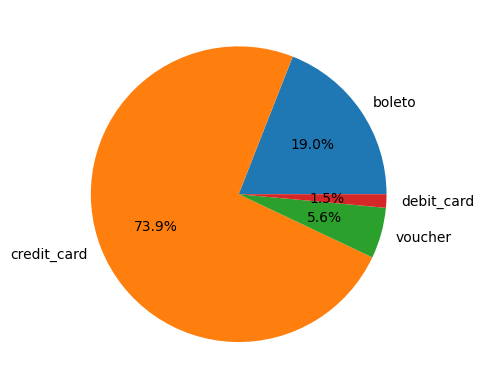

In [ ]:
fig1 = plt.pie(qtde_vendas_ano['contagem'], labels=qtde_vendas_ano['payment_type'], autopct='%1.1f%%')
plt.show()

In [ ]:
fig2.show()

In [ ]:
fig3.show()

In [ ]:
fig4.show()

In [ ]:
fig5.show()